<h1 style="text-align: center;"> CS 6476 Computer Vision :</h1>
 <h3 style="text-align: center;">Problem Set 1 : Edges and Lines</h2>

#### Question 1

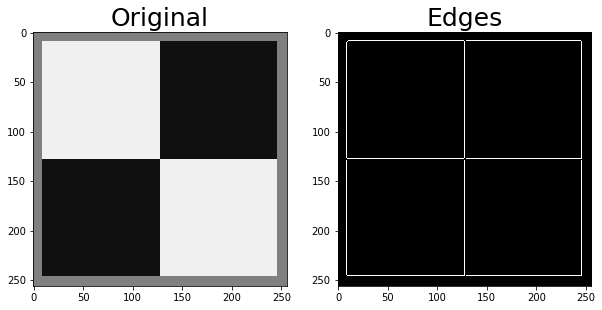

In [2]:
import cv2 
import numpy as np 
import copy as cp
from PIL import Image
import matplotlib.pyplot as plt
img = cv2.imread('ps1-input0.png') 

# Apply edge detection method on the image 
edges = cv2.Canny(img,150,230,apertureSize = 3)
cv2.imwrite('ps1-1-a-0.png',edges)
plt.figure(figsize=(10,10))
plt.subplot(1,2,1),plt.imshow(img),plt.title('Original',fontsize=25)
plt.subplot(1,2,2),plt.imshow(Image.fromarray(edges)),plt.title('Edges',fontsize=25)
plt.show()

#### Question 2:

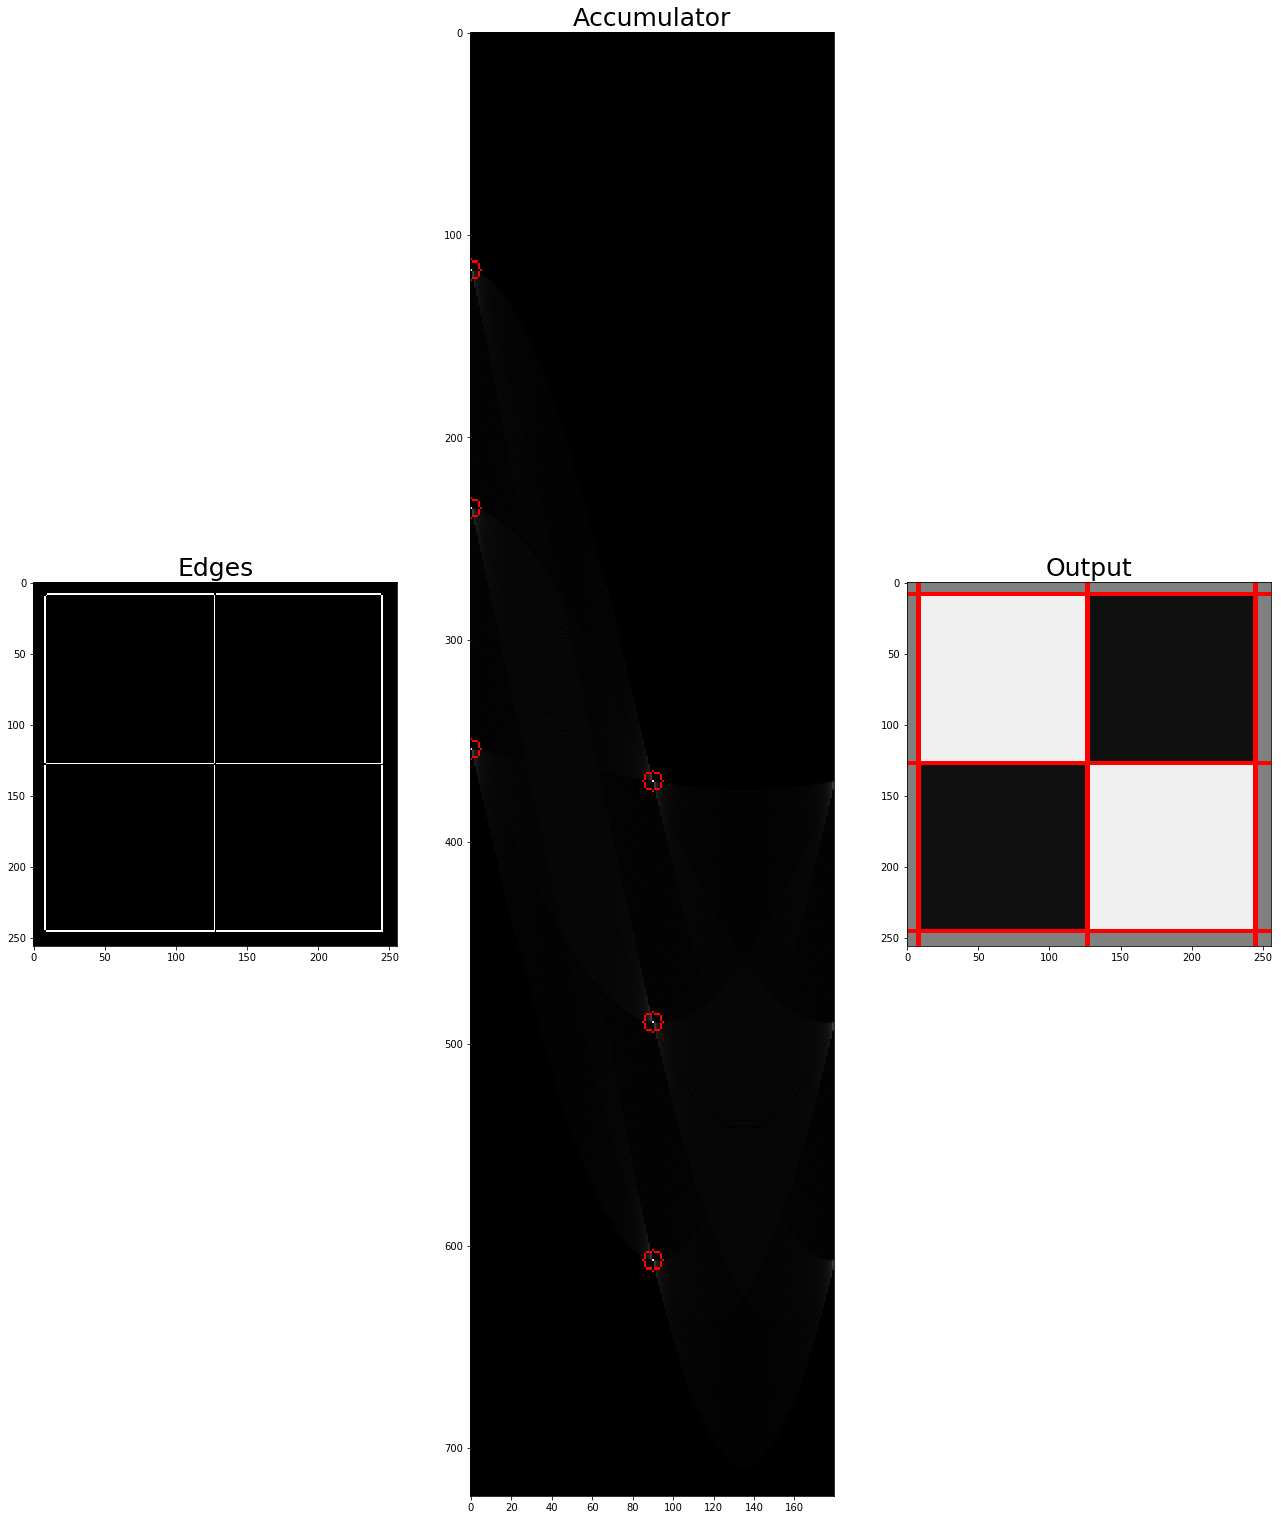

In [3]:




def hough(img,delta_theta=1):
    img_cp = cp.deepcopy(img)
    #theta is between -pi/2 and pi/2
    maxtheta = 90
    mintheta = -90
    #np.cos and np.sin work in rad
    thetas = np.deg2rad(np.arange(mintheta,maxtheta,delta_theta))#delta_theta = 1 seems fine
    cos_i = np.cos(thetas)
    sin_i = np.sin(thetas)
    numthetas = len(thetas)    
    
    width, height = img_cp.shape
    
    #dmax = sqrt(width^2+height^2) 
    dmax = int( np.sqrt(width*width + height*height))
    dmin = -dmax
    
    #We choose delta_d = 1 and numd = 2*dmax
    numd = dmax-dmin
    H = np.zeros((numd,numthetas))
    x_i, y_i = np.nonzero(img_cp)
    for i in range(len(x_i)):
        for theta_i in range(numthetas):
            #to keep d > 0 because it is an index and numd = 2*dmax
            d = int(round(x_i[i]*cos_i[theta_i]+y_i[i]*sin_i[theta_i] + dmax  )) 
            H[d,theta_i]+=1
            if(d > 2*dmax or d < 0) :
                print('over d',d)
#     return H,thetas,ds
    return H,thetas

# def hough_peaks(H,ds,thetas,nb=1):
def hough_peaks_lines(H,thetas,nb=1):    
    H_temp = cp.deepcopy(H)
    peaks = np.zeros((nb,2))
    dmax = int( H_temp.shape[0]/2)
    dmin = -dmax
    i = 0
    while(i<nb):
        #select the max
        idx = np.argmax(H_temp)
        
        #Delete the peak from H_temp 
        H_temp[idx//H_temp.shape[1],idx%H_temp.shape[1]] = 0
        
        #Retrieve real values of d and theta
        dtemp = int(dmin + 1* (idx // H_temp.shape[1])) # d = dmin + delta_d * d_i with delta_d = 1 and d_i = idx // accu.shape[1]
        theta = thetas[idx % H_temp.shape[1]] 
        newItem = True
        for p in peaks:
            if( np.sqrt((abs(p[0]-dtemp)**2) + (abs(p[1]-theta) )**2) < 6):
                newItem = False
        if(newItem):
            peaks[i,0]=dtemp
            peaks[i,1]=theta
            i+=1
        
    return peaks

def hough_lines(img, peaks, thetas, outfile='test.jpg'):
    img_out = cp.deepcopy(img)
    for peak in peaks:
        d = peak[0]
        theta = peak[1] 
        #Retrieve the line
        a = np.cos(theta); b = np.sin(theta)
        #Create the first point
        p0 = tuple( (d * np.array([a,b])).astype(int))
        #Create a 2nd point
        p1 = tuple((p0 + 10000 * np.array([-b,a])).astype(int))
        p2 = tuple((p0 - 10000 * np.array([-b,a])).astype(int))
        cv2.line(img_out,(p2[1],p2[0]), (p1[1],p1[0]), (255,0,0),2)
    return img_out


def draw_peaks(accu,peaks,thetas):
    #copy accu in a grayscale image
    img_peaks = np.zeros((accu.shape[0],accu.shape[1],3),np.uint8)
    dmax = int( accu.shape[0]/2)
    dmin = -dmax
    img_peaks[:,:,0] = accu
    img_peaks[:,:,1] = accu
    img_peaks[:,:,2] = accu
    pt_l = []
    for p in peaks :
        #retrieve indexes of theta and d
        theta_i, = np.where(thetas == p[1])
        # dmin<d<dmax
        d_i = p[0]-dmin
        pt_l.append( tuple((int(theta_i),int(d_i))))

    for pt in pt_l:
        cv2.circle(img_peaks,pt, 5, (255,0,0))
    return img_peaks


accu, thetas= hough(edges)

peaks = hough_peaks_lines(accu,thetas,nb=6)
img_out = hough_lines(img,peaks,thetas,outfile='ps1-2-a-1.png')
        
# accumulator, thetas, rhos = hough_line(edges)
cv2.imwrite('ps1-2-a-0-1.jpg',draw_peaks(accu,peaks,thetas))
cv2.imwrite('ps1-2-a-0-2.jpg',img_out)
plt.figure(figsize=(30,30))
plt.subplot(1,4,2),plt.imshow(Image.fromarray(edges)),plt.title('Edges',fontsize=25)
plt.subplot(1,4,3),plt.imshow(Image.fromarray(draw_peaks(accu,peaks,thetas))),plt.title('Accumulator',fontsize=25)
plt.subplot(1,4,4),plt.imshow(img_out),plt.title('Output',fontsize=25)
plt.show()


I changed multiple time the value and the deviation of d to see what would be the best parameters.
I finally took the diagonal of the image as the maximum value $d_{max}$ of $d$ with $2d_{max}$ different values of $d$. I also used a range from -90° to 90° with a deviation of 1 as theta. 

#### Question 3 :

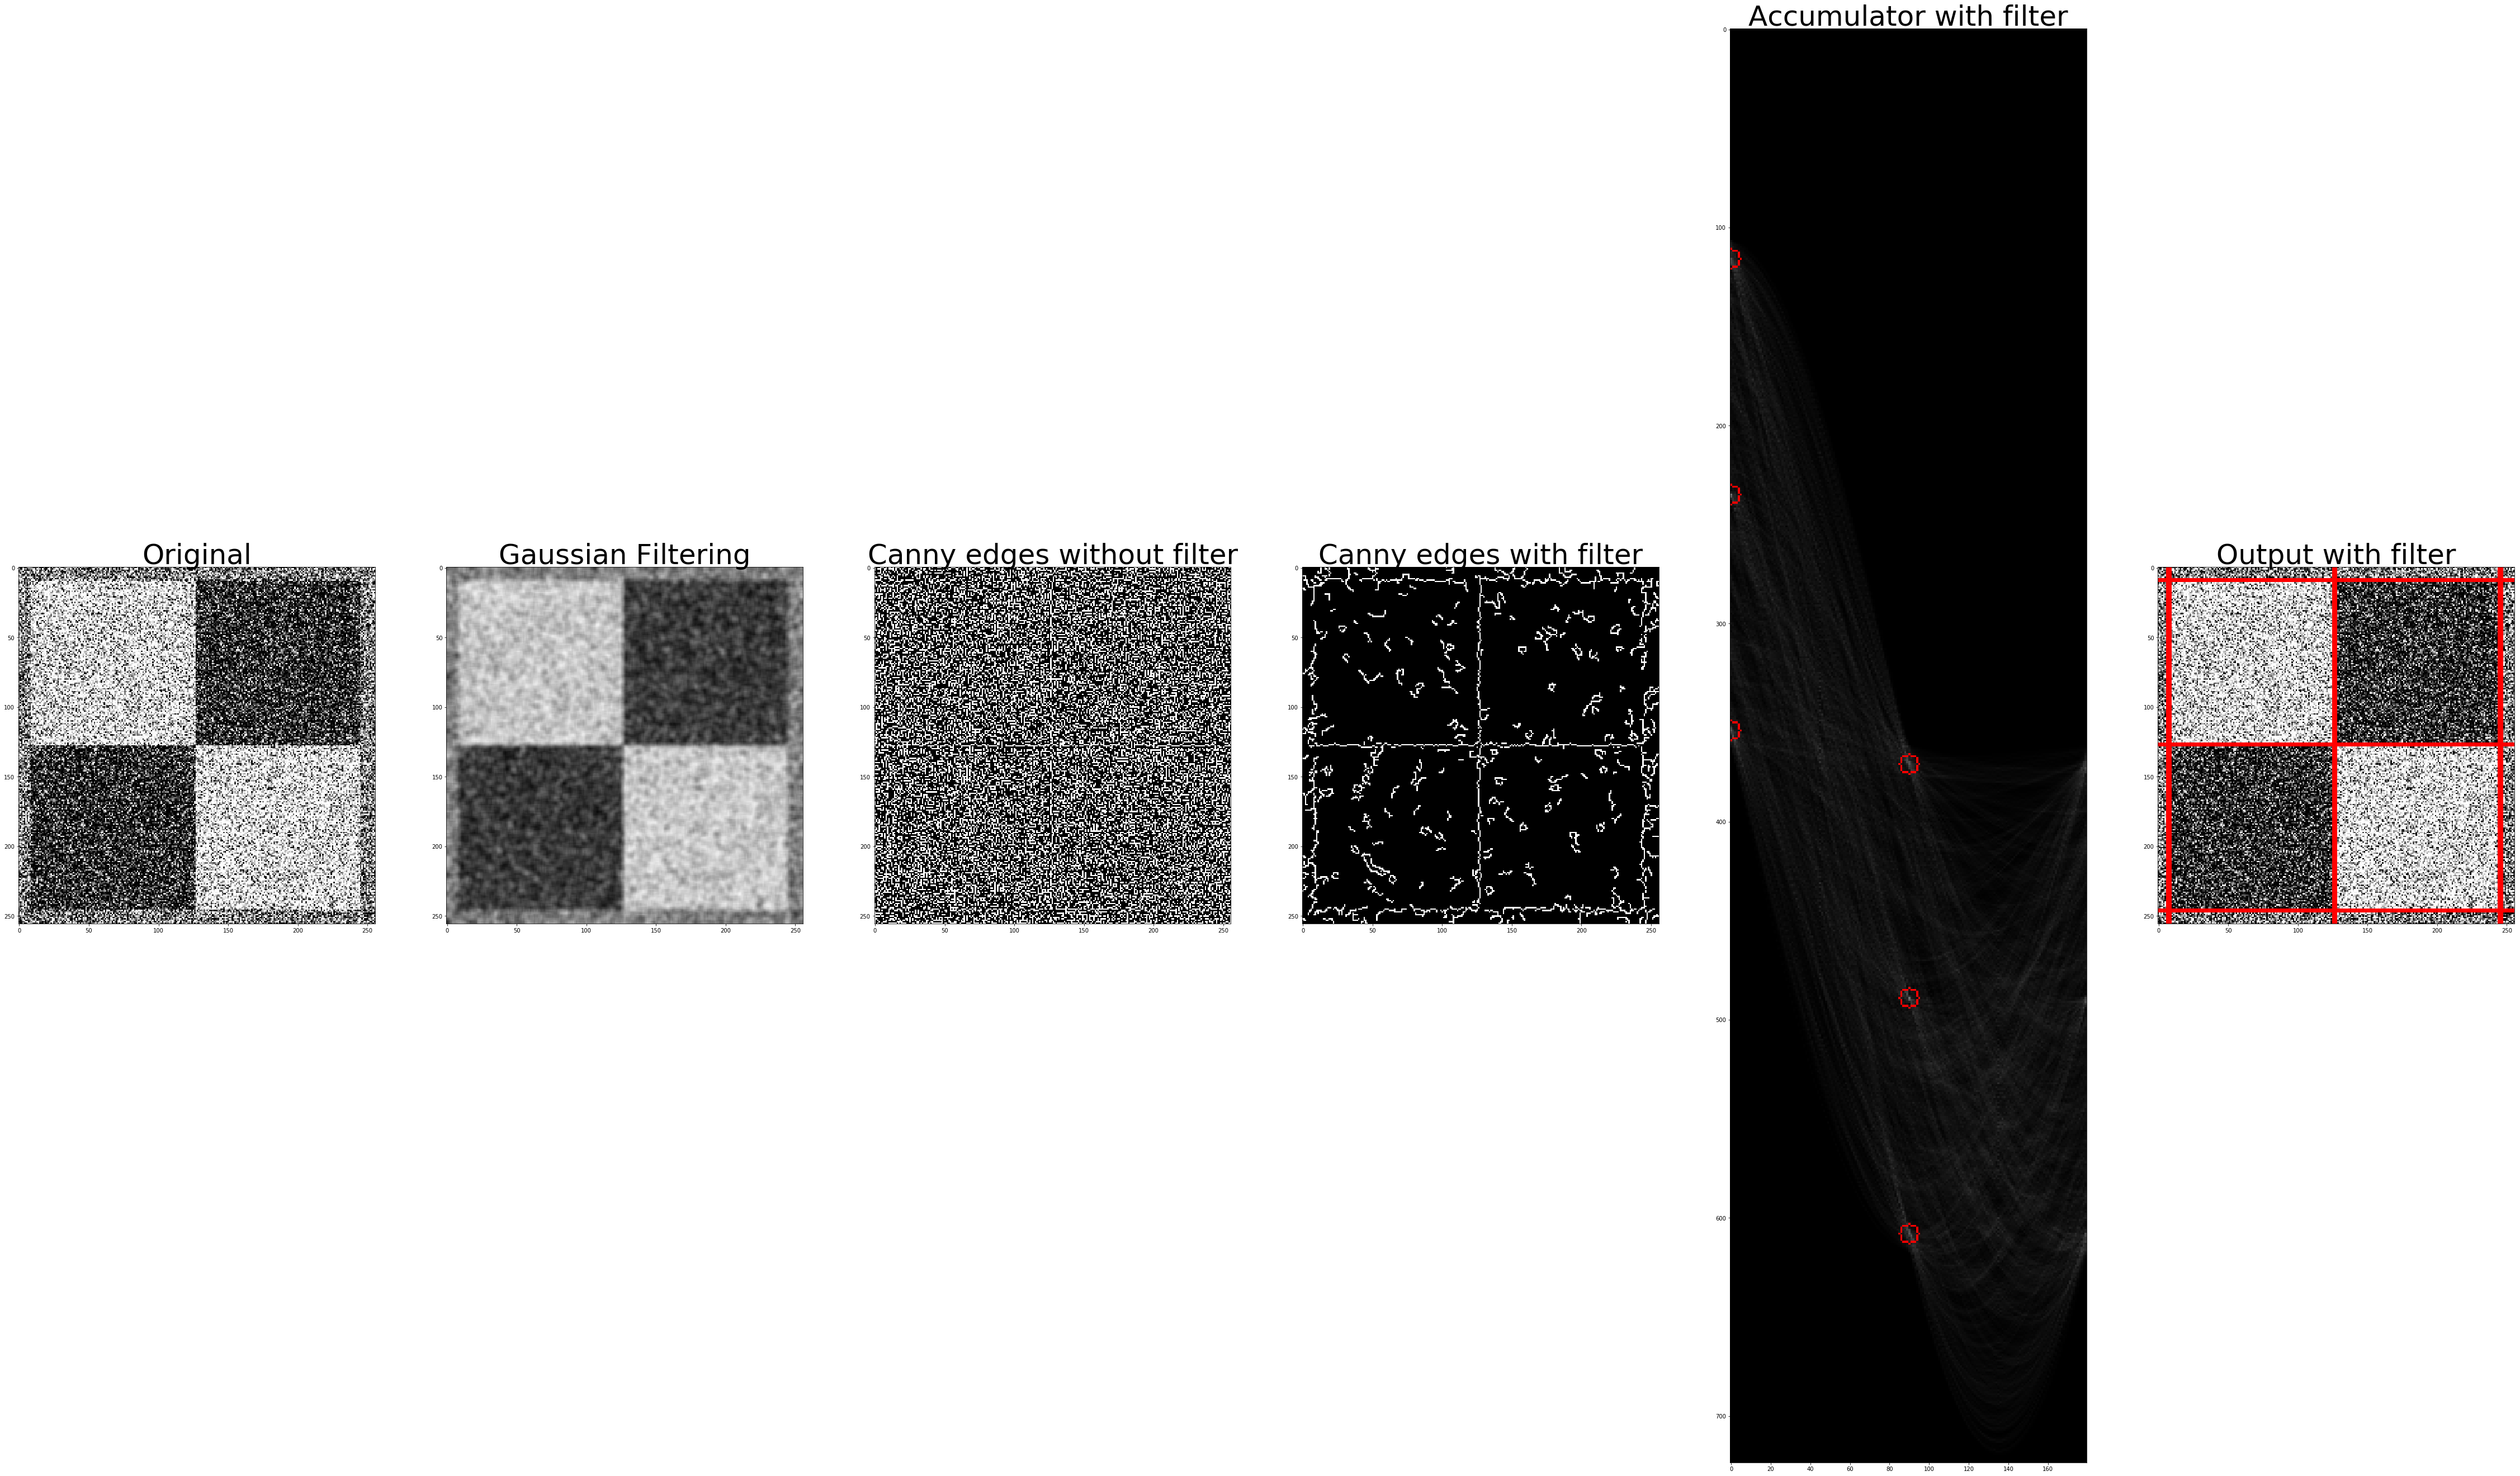

In [4]:
img_noise = cv2.imread('ps1-input0-noise.png')

#Apply a gaussian filter with a kernel size = 5x5
dst= cv2.GaussianBlur(img_noise,(5,5),2) #sigma = 2 seems to be enough

edges_smothed = cv2.Canny(dst,120,210)
edges_noise = cv2.Canny(img_noise,120,210)
accu_noise, thetas_noise = hough(edges_smothed)
peaks_noise = hough_peaks_lines(accu_noise,thetas_noise,nb=6)
img_out_noise = hough_lines(img_noise,peaks_noise,thetas_noise)

cv2.imwrite('ps1-3-a-0.jpg',dst)
cv2.imwrite('ps1-3-b-0-1.jpg',edges_noise)
cv2.imwrite('ps1-3-b-0-2.jpg',edges_smothed)
cv2.imwrite('ps1-3-c-0-1.jpg',draw_peaks(accu_noise,peaks_noise,thetas_noise))
cv2.imwrite('ps1-3-c-0-2.jpg',img_out_noise)

plt.figure(figsize=(80,80))
plt.subplot(1,6,1),plt.imshow(img_noise),plt.title('Original',fontsize=50)
plt.subplot(1,6,2),plt.imshow(dst),plt.title('Gaussian Filtering',fontsize=50)
plt.subplot(1,6,3),plt.imshow(Image.fromarray(edges_noise)),plt.title('Canny edges without filter',fontsize=50)
plt.subplot(1,6,4),plt.imshow(Image.fromarray(edges_smothed)),plt.title('Canny edges with filter',fontsize=50)
plt.subplot(1,6,5),plt.imshow(Image.fromarray(draw_peaks(accu_noise,peaks_noise,thetas_noise))),plt.title('Accumulator with filter',fontsize=50)
plt.subplot(1,6,6),plt.imshow(Image.fromarray(img_out_noise)),plt.title('Output with filter',fontsize=50)
plt.show()

In order to get the best result I had to choose carefully the thresholds of the gaussian blur. Indeed, we need to design the filter so that we can remove the noise without loosing the information about the edges. To do so I took a small value of $\sigma$ for the filter with a little kernel size and use a high value for the high threshold (210). Hence I reduce the intensity of the noise with the filter and then remove it thanks to the high threshold of canny algorithm.

#### Question 4 :

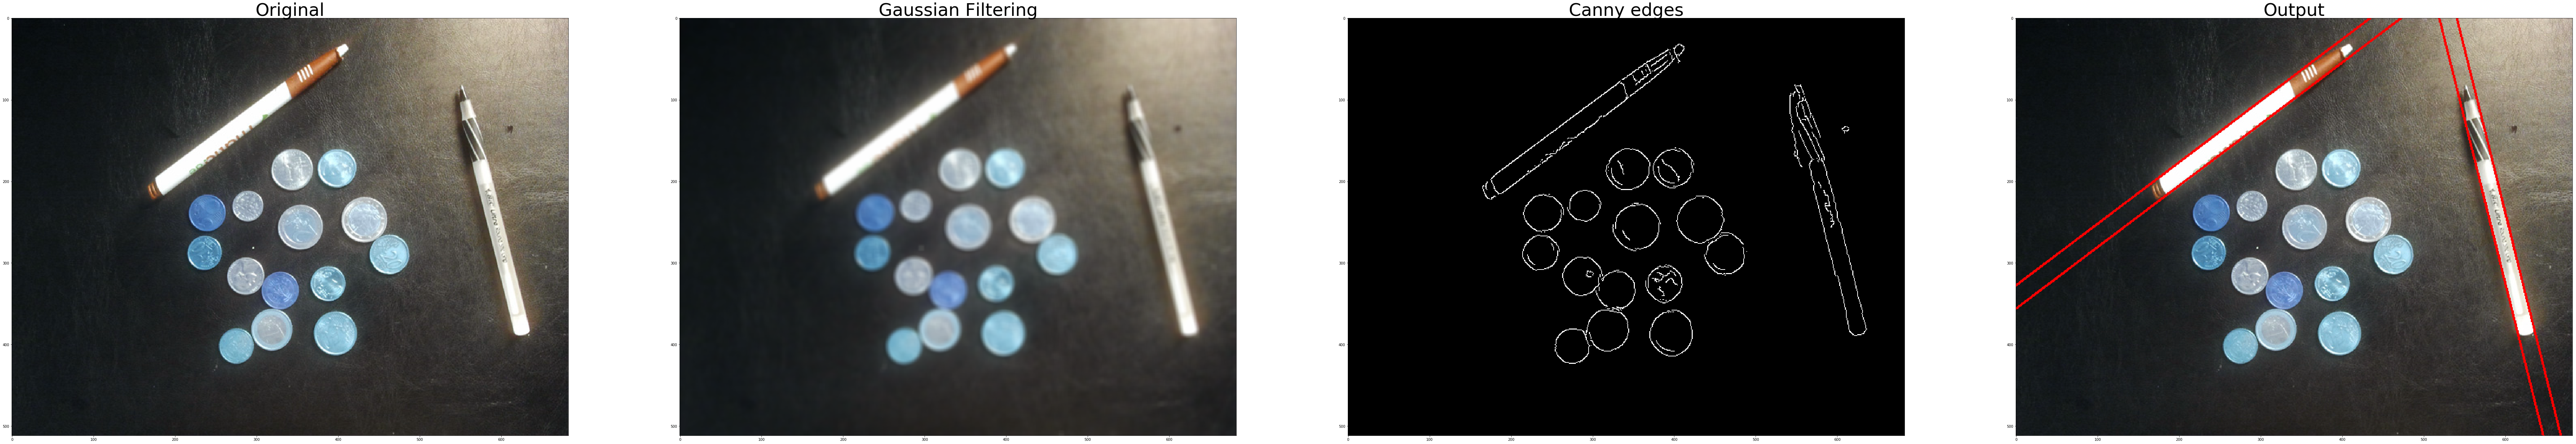

In [93]:
img_noise_2 = cv2.imread('ps1-input1.jpg')
gray_2 = cv2.cvtColor(img_noise_2,cv2.COLOR_BGR2GRAY) 
#Apply a gaussian filter with a kernel size = 7x7
dst2 = cv2.GaussianBlur(img_noise_2,(7,7),5)

cv2.imwrite('ps1-4-a-1.jpg',dst2)

edges_smothed_2 = cv2.Canny(dst2,50,100)

cv2.imwrite('ps1-4-b-1.jpg',edges_smothed)
edges_noise_2 = cv2.Canny(img_noise_2,50,100)
accu_noise_2, thetas_noise_2 = hough(edges_smothed_2)
peaks_noise_2 = hough_peaks_lines(accu_noise_2,thetas_noise_2,nb=4)
img_out_noise_2 = hough_lines(img_noise_2,peaks_noise_2,thetas_noise_2,outfile='ps1-6-a-2.png')

cv2.imwrite('ps1-4-c-1.jpg',img_out_noise_2)

plt.figure(figsize=(130,130))
plt.subplot(1,4,1),plt.imshow(img_noise_2),plt.title('Original',fontsize=50)
plt.subplot(1,4,2),plt.imshow(dst2),plt.title('Gaussian Filtering',fontsize=50)
plt.subplot(1,4,3),plt.imshow(Image.fromarray(edges_smothed_2)),plt.title('Canny edges',fontsize=50)
plt.subplot(1,4,4),plt.imshow(Image.fromarray(img_out_noise_2)),plt.title('Output',fontsize=50)
plt.show()

This image is very "noisy" on the upper right side. Therefore to properly  detect lines I had to pre process the image to get rid of this noise. In order to do that I used a Gaussian Blur with a relatively big kernel size and a relatively big standard deviation. Since I reduced a lot the intensity of the image with the blur I also used relatively low thresholds (50 and 100) for the canny algorithm.

#### Question 5 :

In [94]:
def hough_peaks_circles(accu, num_peaks = 12):#12 seems to work fine with input1
    h_temp = cp.deepcopy(accu)
    peaks = np.zeros((num_peaks,2))
    values = np.zeros(num_peaks)
    for i in range(num_peaks):
        
        idx = np.argmax(h_temp)
            
        #get the value
        value = h_temp[idx//h_temp.shape[1],idx%h_temp.shape[1]]
            
        #Delete the peak from H_temp 
        h_temp[idx//h_temp.shape[1],idx%h_temp.shape[1]] = 0
        a = idx // h_temp.shape[1]
        b = idx % h_temp.shape[1]
        peaks[i,0]=a
        peaks[i,1]=b
        values[i]=value
    return peaks, values
                            
    
def hough_circles_acc(img,r):
    h = np.zeros(img.shape)
    xs,ys = np.nonzero(img)
    for i_xy in range(len(xs)):
        
        #np.cos and np.sin work in rad
        thetas = np.deg2rad(np.arange(0,360,1))
        a_s = (ys[i_xy] - r * np.sin(thetas)).astype(np.uint)
        b_s = (xs[i_xy] - r * np.cos(thetas)).astype(np.uint)
        for i_ab in range(len(a_s)):
            #the centers can't be out of the image
            if(a_s[i_ab] >= 0 and b_s[i_ab] >= 0 and a_s[i_ab]<img.shape[0] and b_s[i_ab]<img.shape[1] ):
                h[a_s[i_ab],b_s[i_ab]]+=1;
    return h
     
def find_circles(img,rad_min=14,rad_max=30,num=14,delta_rad = 1,n_peaks=12):
    
    
    peaks = np.zeros((num,3))
    values = np.zeros(num)
    for r in range(rad_min,rad_max):
        print('radius = ',r)
        h = hough_circles_acc(img,r)
        peaks_temp,values_temp = hough_peaks_circles(h,n_peaks)
        for i in range(len(values_temp)):
            redondant = False
            for p in peaks:               
                if( np.sqrt((abs(p[0]-peaks_temp[i][0])**2) + (abs(p[1]-peaks_temp[i][1]) )**2) < 30  ):
                    redondant = True
                    break
            if(values_temp[i]>=min(values) and redondant==False):
                peaks[np.argmin(values)] = [peaks_temp[i][0],peaks_temp[i][1],r]
                
                values[np.argmin(values)] = values_temp[i]
        
    return peaks,values

def draw_circles(img,peaks):
    img_out = cp.deepcopy(img)
    for p in peaks:
        cv2.circle(img_out,(int(p[0]),int(p[1])),int(p[2]),(0,255,0),5)
    return img_out


        


radius =  20
radius =  21
radius =  22
radius =  23
radius =  24
radius =  25
radius =  26
radius =  27
radius =  28
radius =  29


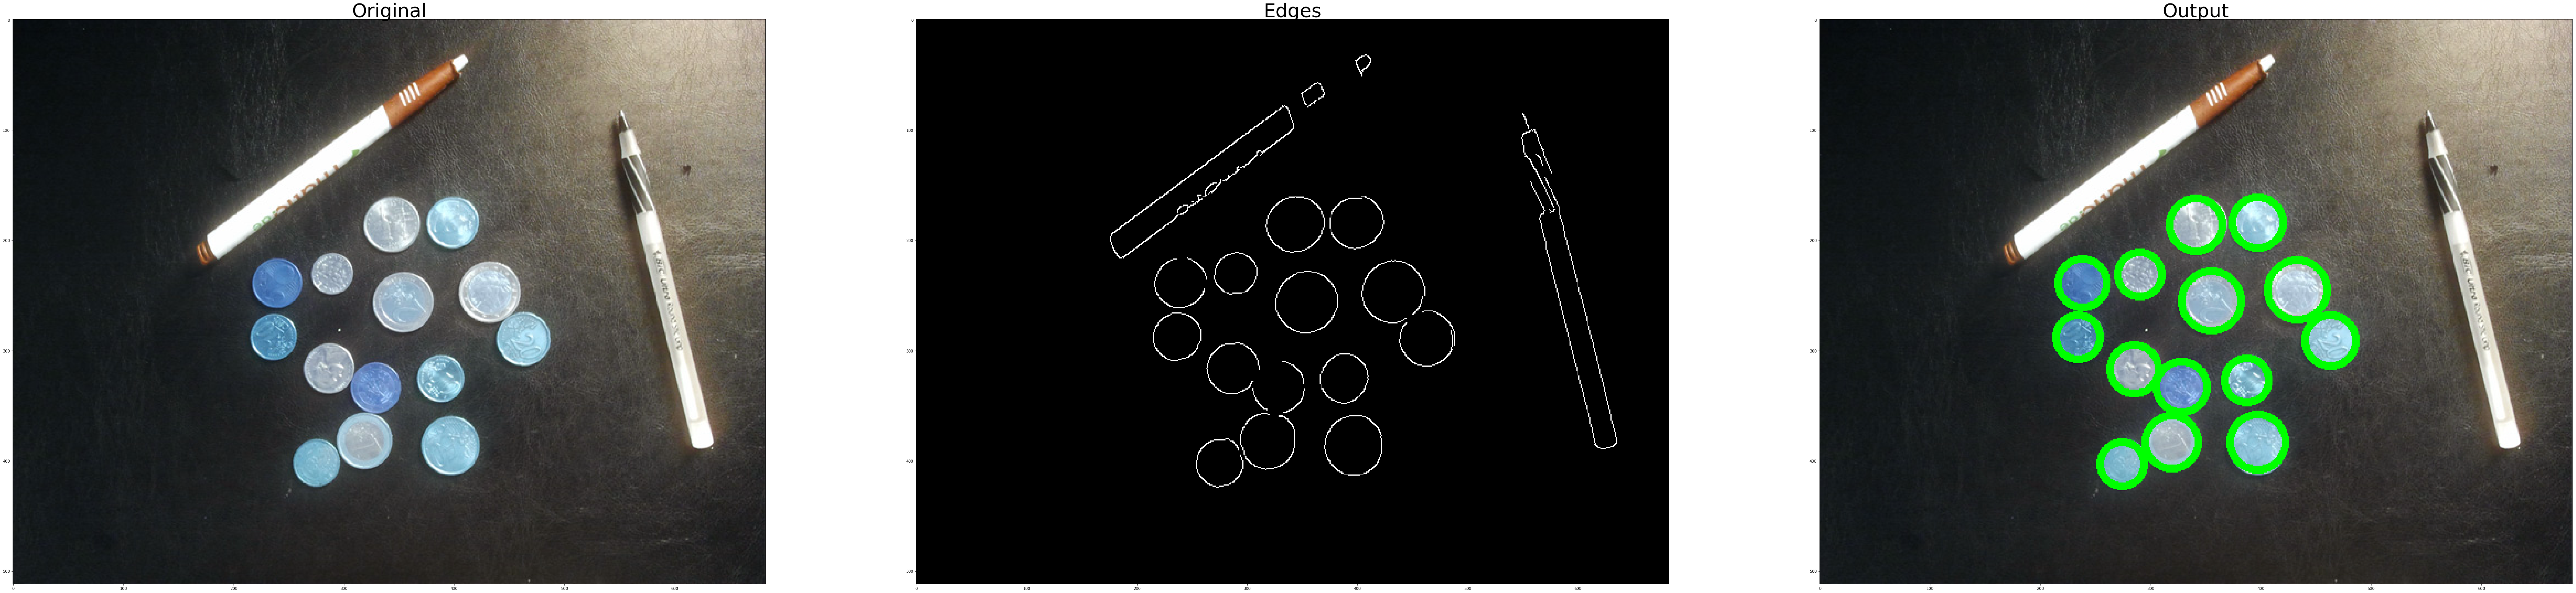

In [95]:
img_circles = cv2.imread('ps1-input1.jpg')
img_cp = cp.deepcopy(img_circles)
gray_circles = cv2.cvtColor(img_cp,cv2.COLOR_BGR2GRAY) 

img_filtered = cv2.GaussianBlur(gray_circles,(5,5),3)
    
edges_circles = cv2.Canny(img_filtered,150,230,apertureSize = 3)

peaks_circles,values = find_circles(edges_circles,20,30,14)

img_out = draw_circles(img_circles,peaks_circles)
cv2.imwrite('ps1-5-a-1-0.jpg',edges_circles)
cv2.imwrite('ps1-5-a-1-1.jpg',img_out)
    
plt.figure(figsize=(120,120))
plt.subplot(1,3,1),plt.imshow(Image.fromarray(img_circles)),plt.title('Original',fontsize=50)
plt.subplot(1,3,2),plt.imshow(Image.fromarray(edges_circles)),plt.title('Edges',fontsize=50)
plt.subplot(1,3,3),plt.imshow(Image.fromarray(img_out)),plt.title('Output',fontsize=50)

plt.show()

To find the circles I had to select the right radius range. To find this range I simply launched the algorithm with multiple small ranges. I also mesured the smallest size size of the coins on the plot first plot to find the first range. 

#### Question 6 :

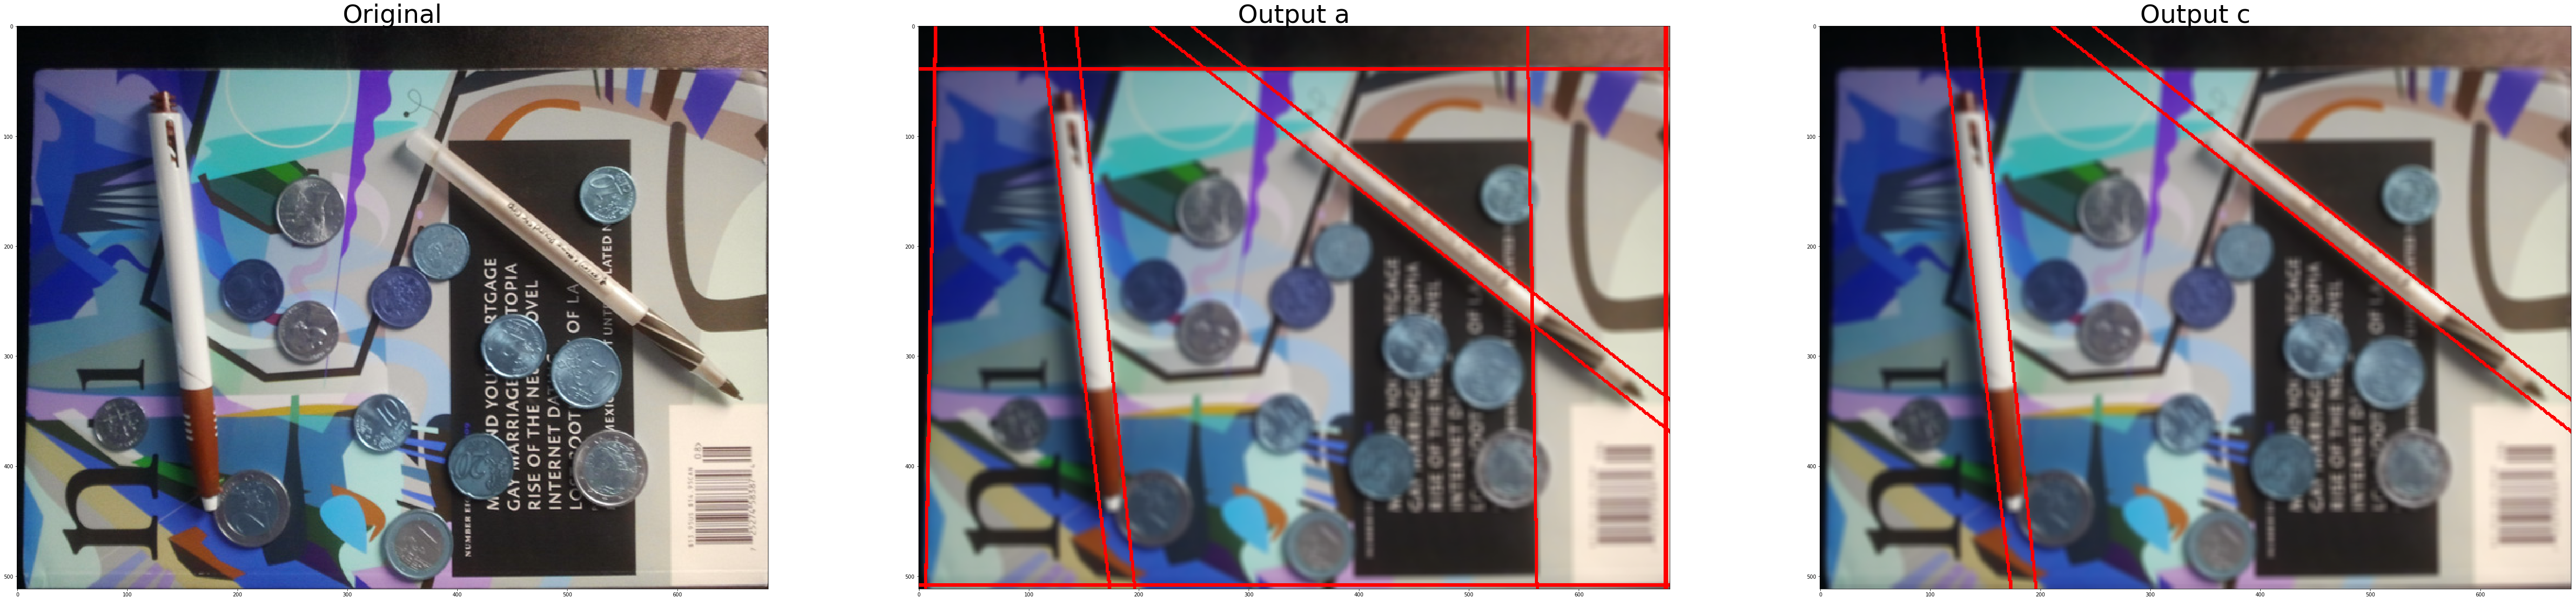

In [96]:
img_noise_2 = cv2.imread('ps1-input2.jpg')
gray_2 = cv2.cvtColor(img_noise_2,cv2.COLOR_BGR2GRAY) 
#Apply a gaussian filter with a kernel size = 7x7
dst2 = cv2.GaussianBlur(img_noise_2,(7,7),5)

def filter_line_peaks(peaks, delta_theta, d_min):
#     peaks_temp = cp.deepcopy(peaks)
    peaks_temp = cp.copy(peaks)
    out_peaks = []
    k = 0
    for k in range(len(peaks_temp)):
        p = peaks_temp[k]
        for j in range(len(peaks_temp)):
            p2 = peaks_temp[j]
            if(p[0] != p2[0] and p[1] != p2[1] and abs(p[0]-p2[0]) < d_min and abs(p[1]-p2[1]) < delta_theta):
                out_peaks.append(p)
                break
    return out_peaks
                

edges_smothed_2 = cv2.Canny(dst2,50,100)
edges_noise_2 = cv2.Canny(img_noise_2,0,200)

accu_noise_2, thetas_noise_2 = hough(edges_smothed_2)

peaks_noise_2 = hough_peaks_lines(accu_noise_2,thetas_noise_2,nb=9)
peaks_filtered = filter_line_peaks(peaks_noise_2,1,30)

img_out_noise_1 = hough_lines(dst2,peaks_noise_2,thetas_noise_2)
img_out_noise_2 = hough_lines(dst2,peaks_filtered,thetas_noise_2,outfile='ps1-6-a-2.png')



plt.figure(figsize=(90,90))
plt.subplot(1,3,1),plt.imshow(img_noise_2),plt.title('Original',fontsize=50)
plt.subplot(1,3,2),plt.imshow(Image.fromarray(img_out_noise_1)),plt.title('Output a',fontsize=50)
plt.subplot(1,3,3),plt.imshow(Image.fromarray(img_out_noise_2)),plt.title('Output c',fontsize=50)
plt.show()

In [97]:
cv2.imwrite('ps1-6-a-2.jpg',img_out_noise_1)
cv2.imwrite('ps1-6-c-2.jpg',img_out_noise_2)

True

There are a lots of false positive. Indeed, the algorithm detects the edges of the book. To only detect the edges of the pens we need to get rid of the peaks generated by the book. To do so we have to select the 2 pairs of lines which are parallel and close to each other.

radius =  25
radius =  26
radius =  27
radius =  28
radius =  29
radius =  30
radius =  31
radius =  32
radius =  33
radius =  34
radius =  35
radius =  36
radius =  37
radius =  38
radius =  39


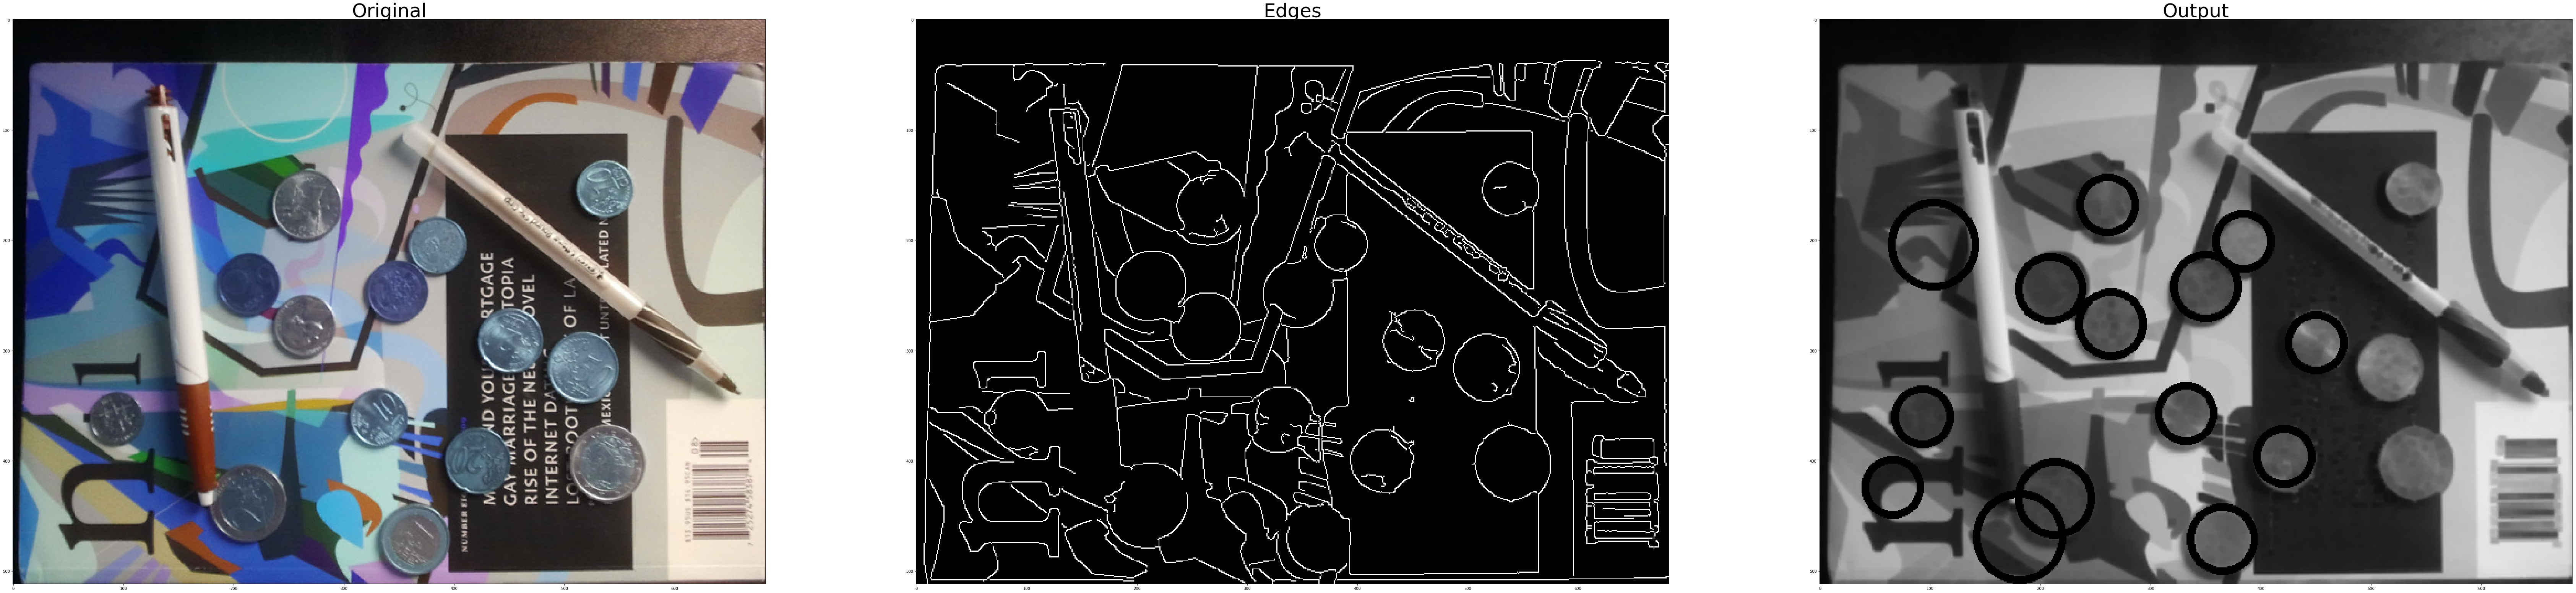

In [98]:
img_circles = cv2.imread('ps1-input2.jpg')
img_cp = cp.deepcopy(img_circles)
gray_circles = cv2.cvtColor(img_cp,cv2.COLOR_BGR2GRAY) 
eroded_img = cv2.erode(gray_circles, np.ones((5,5),np.uint8), 1)

img_filtered = cv2.GaussianBlur(eroded_img,(3,3),1)
edges_circles = cv2.Canny(img_filtered,50,100)

peaks, values = find_circles(edges_circles,25,40,15,1,18)
img_out = draw_circles(img_filtered,peaks)
plt.figure(figsize=(120,120))

plt.subplot(1,3,1),plt.imshow(Image.fromarray(img_circles)),plt.title('Original',fontsize=50)
plt.subplot(1,3,2),plt.imshow(Image.fromarray(edges_circles)),plt.title('Edges',fontsize=50)
plt.subplot(1,3,3),plt.imshow(Image.fromarray(img_out)),plt.title('Output',fontsize=50)
plt.show()     

In [99]:
cv2.imwrite('ps1-7-a-2.jpg',img_out)

True

My "peak finder" look for good matches for every radius. Indeed for every radius it selects the $num_{peaks}$ highest peaks for this radius. Then if some of these peaks are higher than those previously found, they are kept in memory. Hence I tried to adjust the number of peaks selected for each radius. 
I also tried many different parameters for the Canny filter and the Gaussian Blur (size of the kernel, size of $\sigma$). To completely get rid of the noise one should remove the text of the book from the image. However it is actually difficult to do that with a simple Gaussian Blur. Looking over the internet I found a filter called  ["Erosion"](https://docs.opencv.org/3.0-beta/doc/py_tutorials/py_imgproc/py_morphological_ops/py_morphological_ops.html) which reduces  the sizes of white objects over black background. This is usefull in our case since the text is white over a black background. Using this filter before the blur reduces the noise. However, these different processes I use, might delete some information about the three leftmost coins of the image, which my algorithm is currently unable to detect.

#### Question 8 :

radius =  20
radius =  21
radius =  22
radius =  23
radius =  24
radius =  25
radius =  26
radius =  27
radius =  28
radius =  29
radius =  30
radius =  31
radius =  32
radius =  33
radius =  34
radius =  35
radius =  36
radius =  37
radius =  38
radius =  39


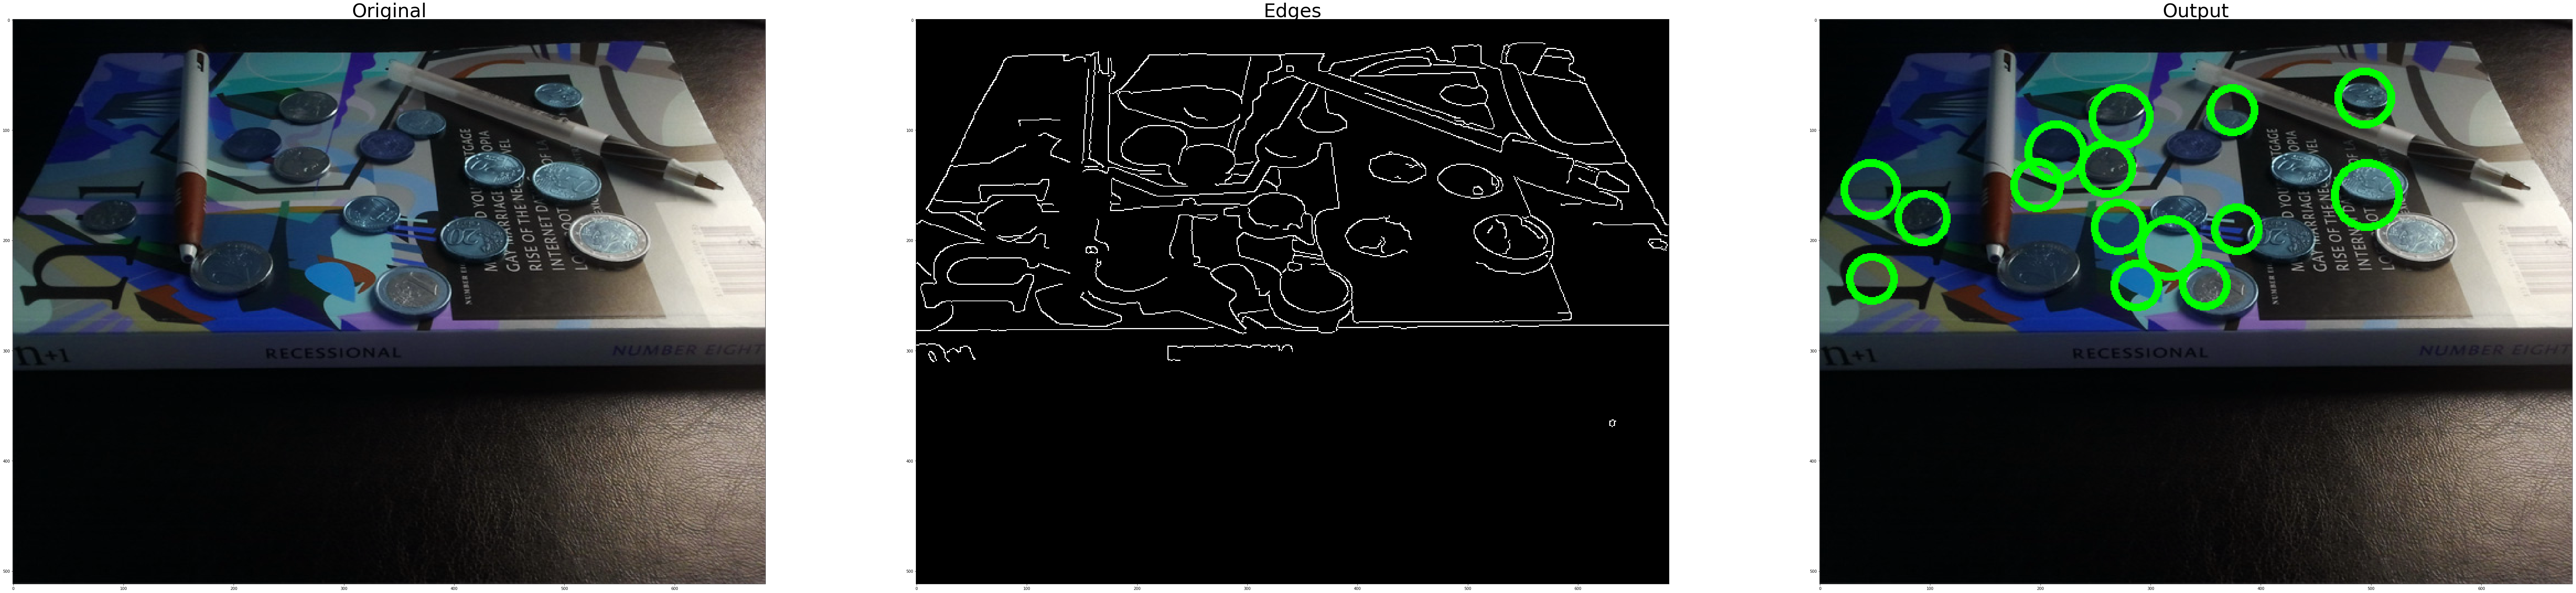

In [100]:
img_circles = cv2.imread('ps1-input3.jpg')
img_cp = cp.deepcopy(img_circles)
gray_circles = cv2.cvtColor(img_cp,cv2.COLOR_BGR2GRAY) 

eroded_img2 = cv2.erode(gray_circles, np.ones((5,5),np.uint8), 1)

img_filtered2 = cv2.GaussianBlur(eroded_img2,(3,3),1)
    
    
edges_circles2 = cv2.Canny(img_filtered2,50,100)


peaks_circles2,values = find_circles(edges_circles2,20,40,15)

img_out = draw_circles(img_circles,peaks_circles2)

plt.figure(figsize=(120,120))
plt.subplot(1,3,1),plt.imshow(Image.fromarray(img_circles)),plt.title('Original',fontsize=50)
plt.subplot(1,3,2),plt.imshow(Image.fromarray(edges_circles2)),plt.title('Edges',fontsize=50)
plt.subplot(1,3,3),plt.imshow(Image.fromarray(img_out)),plt.title('Output',fontsize=50)

plt.show()

In [101]:
cv2.imwrite('ps1-8-3-a.jpg',img_out)

True

Some coins are found. However the detection seems to be inaccurate for most of the circles. First, there is distortion because the optical axis is not perpendicular to the plane of the coins. Hence, on the image, the coins are elliptical in shape while our algorithm only detects circles. In addition, the scene of the coins is poorly lit. To solve the "ellipse problem" one could implement a new Hough algorithm with 4 "parameters" : the location of the center (on the x-axis and the y-axis), the length of the semi-minor axis, the length of the semi-major axis.